In [4]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex


path = "data/"
node_parser = SimpleDirectoryReader(input_dir=path, required_exts=['.txt'])
documents = node_parser.load_data()

In [5]:
documents

[Document(id_='6230a995-0a56-4994-861c-b026ded60f45', embedding=None, metadata={'file_path': '/Users/michieldekoninck/code/Michiel-DK/transcripts_rag/data/2024_1_AA.txt', 'file_name': '2024_1_AA.txt', 'file_type': 'text/plain', 'file_size': 50046, 'creation_date': '2024-09-17', 'last_modified_date': '2024-09-17'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text="Operator: Good afternoon, and welcome to the Alcoa Corporation First Quarter 2024 Earnings Presentation and Conference Call. All participants will be in listen-only mode. [Operator Instructions] Please note, this event is being recorded. I would now like to turn the conference over to James Dwyer, Vice President, Investor Relations and Pension Investments. Please go ahead.\nJames Dwyer: Thank you,

In [7]:
import os
import numpy as np
from typing import List
from scipy.stats import beta
import matplotlib.pyplot as plt
import cohere
from dotenv import load_dotenv

# Load environment variables from a .env file
load_dotenv()

True

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

def split_into_chunks(text: str, chunk_size: int):
    """
    Split a given text into chunks of specified size using RecursiveCharacterTextSplitter.

    Args:
        text (str): The input text to be split into chunks.
        chunk_size (int, optional): The maximum size of each chunk. Defaults to 800.

    Returns:
        list[str]: A list of text chunks.

    Example:
        >>> text = "This is a sample text to be split into chunks."
        >>> chunks = split_into_chunks(text, chunk_size=10)
        >>> print(chunks)
        ['This is a', 'sample', 'text to', 'be split', 'into', 'chunks.']
    """
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0, length_function=len)
    texts = text_splitter.create_documents([text])
    chunks = [text.page_content for text in texts]
    return chunks

def transform(x: float):
    """
    Transformation function to map the absolute relevance value to a value that is more uniformly distributed between 0 and 1. The relevance values given by the Cohere reranker tend to be very close to 0 or 1. This beta function used here helps to spread out the values more uniformly.

    Args:
        x (float): The absolute relevance value returned by the Cohere reranker

    Returns:
        float: The transformed relevance value
    """
    a, b = 0.4, 0.4  # These can be adjusted to change the distribution shape
    return beta.cdf(x, a, b)

def rerank_chunks(query: str, chunks: List[str]):
    """
    Use Cohere Rerank API to rerank the search results

    Args:
        query (str): The search query
        chunks (list): List of chunks to be reranked

    Returns:
        similarity_scores (list): List of similarity scores for each chunk
        chunk_values (list): List of relevance values (fusion of rank and similarity) for each chunk
    """
    model = "rerank-english-v3.0"
    client = cohere.Client(api_key=os.environ["CO_API_KEY"])
    decay_rate = 30

    reranked_results = client.rerank(model=model, query=query, documents=chunks)
    results = reranked_results.results
    reranked_indices = [result.index for result in results]
    reranked_similarity_scores = [result.relevance_score for result in results] # in order of reranked_indices
    
    # convert back to order of original documents and calculate the chunk values
    similarity_scores = [0] * len(chunks)
    chunk_values = [0] * len(chunks)
    for i, index in enumerate(reranked_indices):
        absolute_relevance_value = transform(reranked_similarity_scores[i])
        similarity_scores[index] = absolute_relevance_value
        chunk_values[index] = np.exp(-i/decay_rate)*absolute_relevance_value # decay the relevance value based on the rank

    return similarity_scores, chunk_values

def plot_relevance_scores(chunk_values: List[float], start_index: int = None, end_index: int = None) -> None:
    """
    Visualize the relevance scores of each chunk in the document to the search query

    Args:
        chunk_values (list): List of relevance values for each chunk
        start_index (int): Start index of the chunks to be plotted
        end_index (int): End index of the chunks to be plotted

    Returns:
        None

    Plots:
        Scatter plot of the relevance scores of each chunk in the document to the search query
    """
    plt.figure(figsize=(12, 5))
    plt.title(f"Similarity of each chunk in the document to the search query")
    plt.ylim(0, 1)
    plt.xlabel("Chunk index")
    plt.ylabel("Query-chunk similarity")
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(chunk_values)
    plt.scatter(range(start_index, end_index), chunk_values[start_index:end_index])

In [9]:
# File path for the input document
FILE_PATH = "data/2024_2_AMD.txt"

with open(FILE_PATH, 'r') as file:
    text = file.read()

chunks = split_into_chunks(text, chunk_size=800)

print (f"Split the document into {len(chunks)} chunks")

Split the document into 79 chunks


In [12]:
# Example query that requires a longer result than a single chunk
query = "Datacenter growth"

similarity_scores, chunk_values = rerank_chunks(query, chunks)

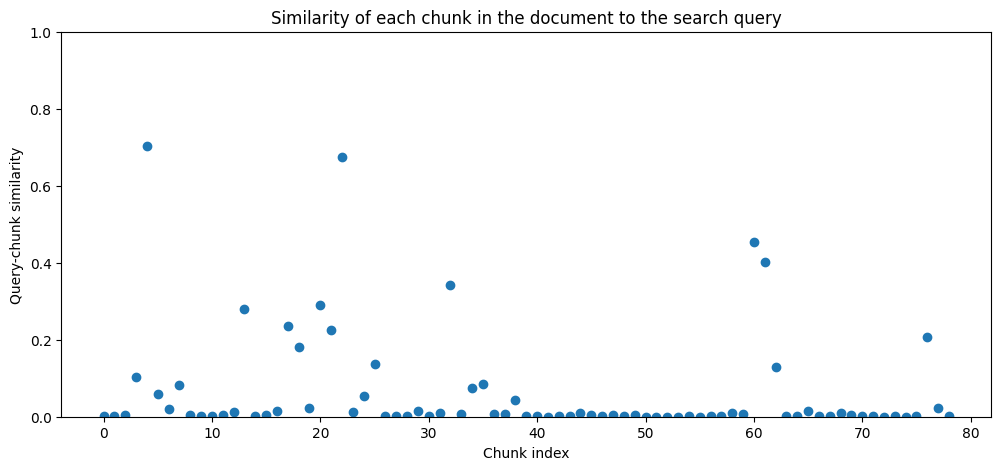

In [13]:
plot_relevance_scores(chunk_values)